In [1]:
#! pip install -q kaggle

In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list
#! kaggle datasets download -d grouplens/movielens-20m-dataset
#! unzip movielens-20m-dataset.zip

In [ ]:
#!pip install lightfm
#!pip install optuna 
#!pip install tensorboardX
#!pip install surprise

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
from lightfm import LightFM
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl 
import seaborn as sns

np.random.seed(31337)

In [6]:
#Читаем дату

df = pd.read_csv("rating.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [7]:
moviedf = pd.read_csv("movie.csv")
moviedf

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [ ]:
#Слишком много данных, не влезает
df = df[::2]

In [10]:
#Выделяем тестовую и обучающую выборку
df = df[['userId',	'movieId',	'rating']]
df["test"] = np.random.random(len(df)) >= 0.7
df

,userId,movieId,rating,test
0,1,2,3.5,True
2,1,32,3.5,True
4,1,50,3.5,False
6,1,151,4.0,False
8,1,253,4.0,False
...,...,...,...,...
20000254,138493,61160,4.0,True
20000256,138493,66762,4.5,True
20000258,138493,68954,4.5,False
20000260,138493,69644,3.0,False


In [11]:
user_counts = df[~df["test"]].groupby("userId").size()
users = set(user_counts[user_counts >= 5].index.values)

In [12]:
movie_counts = df[~df["test"]].groupby("movieId").size()
movies = set(movie_counts[movie_counts >= 5].index.values)

In [13]:
train_data = df[~df["test"] & df["userId"].isin(users) & df["movieId"].isin(movies)]
test_data = df[df["test"] & df["userId"].isin(users) & df["movieId"].isin(movies)]

len(train_data), len(test_data)

(6982886, 2989482)

In [14]:
#Запихиваем необходимую информацию о Юзерах, Фильма и их жанрах
dataset = ld.Dataset()
dataset.fit(df['userId'].unique(), df['movieId'].unique())

In [15]:
genres = list(moviedf['genres'].str.split('|').explode().unique())

In [16]:
dataset.fit_partial(item_features=genres)

In [17]:
num_users, num_items = dataset.interactions_shape()
num_users, num_items

(138493, 23974)

In [21]:
#Строим interactions пользователей и фильмов
train_interactions, train_interactionst_weights = dataset.build_interactions(train_data[["userId", "movieId"]].itertuples(index=False, name=None))
test_interactions, test_interactions_weights = dataset.build_interactions(test_data[["userId", "movieId"]].itertuples(index=False, name=None))

In [22]:
#Добавляем для фильмов их жанры(train_items_features)
moviedf['features'] = moviedf['genres'].str.split('|')
moviedf.head()

,movieId,title,genres,features
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


In [23]:
moviedf['features'].map(len).value_counts(dropna=False)

1     10829
2      8809
3      5330
4      1724
5       477
6        83
7        20
8         5
10        1
Name: features, dtype: int64

In [24]:
def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [25]:
known_items_filter = moviedf['movieId'].isin(df['movieId'].unique())
train_items_features = dataset.build_item_features(
    df_to_tuple_list_iterator(
        moviedf.loc[known_items_filter, ['movieId', 'features']]
    )
)
train_items_features

<23974x23994 sparse matrix of type '<class 'numpy.float32'>'
	with 72490 stored elements in Compressed Sparse Row format>

In [36]:
#Фит модэли (использую для подбора гиперпараметров)
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
        
    return model, precisions_at

#Функция с перебором гиперпараметров для optuna
def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [30]:
#Сам перебор
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2022-04-04 13:31:18,506] A new study created in memory with name: no-name-9bfd9a76-4b27-4e4f-8952-cb54db8bf552
[I 2022-04-04 14:27:07,963] Trial 0 finished with value: 0.210688516497612 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.0001, 'max_sampled': 50, 'user_alpha': 0.0001, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.210688516497612.
[I 2022-04-04 14:53:27,433] Trial 1 finished with value: 0.2523970305919647 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 1 with value: 0.2523970305919647.
[I 2022-04-04 15:34:13,533] Trial 2 finished with value: 0.2631324529647827 and parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.01, 'max_sampled': 20, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 2 with value: 0.2631324529647827.
[I 2022-04-04 16:00:04,076] Trial 3 finished with value: 0.25220927596092224 and parameters: {'lo

In [34]:
#Модэль слишком долго обучалась, интараптнул, захардкодил неплохой результат
best_params = {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.0, 'item_alpha': 0.0}

In [44]:
#Прогоняем модэль на 10и эпохах, precision_at_k увеличивается, замечательно
model = lightfm.LightFM(
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    )
precisions_at = []

In [45]:
from tqdm import tqdm
for epoch in tqdm(range(10)):
    model = model.fit_partial(train_interactions, num_threads=10)
    precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=10, num_threads=10)
    print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
    precisions_at.append(np.mean(precision_at))

 10%|█         | 1/10 [05:39<50:55, 339.46s/it]

0:	0.07861822098493576 +/- 0.0005355069964853721


 20%|██        | 2/10 [11:15<45:00, 337.56s/it]

1:	0.08344322443008423 +/- 0.0005514730780802566


 30%|███       | 3/10 [16:51<39:16, 336.67s/it]

2:	0.08575322479009628 +/- 0.0005621011609751772


 40%|████      | 4/10 [22:27<33:38, 336.43s/it]

3:	0.08733563870191574 +/- 0.0005692146342172894


 50%|█████     | 5/10 [28:03<28:01, 336.35s/it]

4:	0.08839761465787888 +/- 0.0005740640781985748


 60%|██████    | 6/10 [33:39<22:24, 336.22s/it]

5:	0.08928076177835464 +/- 0.0005777684954344881


 70%|███████   | 7/10 [39:15<16:48, 336.13s/it]

6:	0.09009195864200592 +/- 0.0005802926882524933


 80%|████████  | 8/10 [44:51<11:12, 336.06s/it]

7:	0.09060730785131454 +/- 0.0005816340581666985


 90%|█████████ | 9/10 [50:26<05:35, 335.84s/it]

8:	0.09113865345716476 +/- 0.0005830324766575308


100%|██████████| 10/10 [56:12<00:00, 337.22s/it]

9:	0.0916162058711052 +/- 0.0005839965542944296


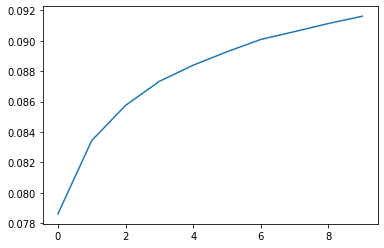

In [55]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

In [45]:
#Делаем всё тоже самое, только теперь не учитываем жанры фильмов, ситуация аналогичная, но precision_at_k меньше, чем у предыдущей модэльки

In [46]:
len(train_data), len(test_data)

(6982886, 2989482)

In [49]:
no_feature_dataset = ld.Dataset()
no_feature_dataset.fit(df['userId'].unique(), df['movieId'].unique())

In [54]:
no_feature_train_interactions, _ = no_feature_dataset.build_interactions(train_data[["userId", "movieId"]].itertuples(index=False, name=None))
no_feature_test_interactions, _ = no_feature_dataset.build_interactions(test_data[["userId", "movieId"]].itertuples(index=False, name=None))

In [56]:
no_feature_model = lightfm.LightFM(
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    )
no_feature_precisions_at = []

In [57]:
from tqdm import tqdm
for epoch in tqdm(range(10)):
    no_feature_model = no_feature_model.fit_partial(no_feature_train_interactions, num_threads=10)
    no_feature_precision_at = lv.precision_at_k(no_feature_model, no_feature_test_interactions, train_interactions=no_feature_train_interactions, k=10, num_threads=10)
    print(f"{epoch}:\t{np.mean(no_feature_precision_at)} +/- {ss.sem(no_feature_precision_at) * 1.96}")
    no_feature_precisions_at.append(np.mean(no_feature_precision_at))

 10%|█         | 1/10 [05:53<52:57, 353.11s/it]

0:	0.07805196195840836 +/- 0.0005314348147537562


 20%|██        | 2/10 [11:31<45:57, 344.72s/it]

1:	0.08063893020153046 +/- 0.0005418122618731021


 30%|███       | 3/10 [17:07<39:42, 340.42s/it]

2:	0.08282899856567383 +/- 0.0005510349576104803


 40%|████      | 4/10 [22:42<33:50, 338.48s/it]

3:	0.08534982055425644 +/- 0.0005601997386092677


 50%|█████     | 5/10 [28:17<28:05, 337.15s/it]

4:	0.08726731687784195 +/- 0.0005687510800825712


 60%|██████    | 6/10 [33:52<22:25, 336.34s/it]

5:	0.08852409571409225 +/- 0.0005736965499288624


 70%|███████   | 7/10 [39:27<16:48, 336.10s/it]

6:	0.0896267518401146 +/- 0.0005781624810151002


 80%|████████  | 8/10 [45:03<11:11, 335.78s/it]

7:	0.09062839299440384 +/- 0.0005818720558517989


 90%|█████████ | 9/10 [50:37<05:35, 335.38s/it]

8:	0.09093732386827469 +/- 0.0005825368351591472


100%|██████████| 10/10 [56:12<00:00, 337.29s/it]

9:	0.09139814972877502 +/- 0.0005835950488531303


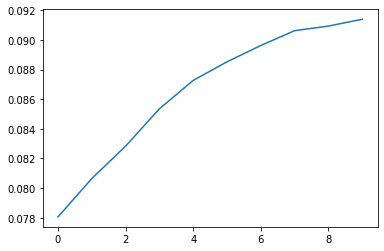

In [58]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(no_feature_precisions_at)), no_feature_precisions_at)

pass